In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline

Read csv file

In [209]:
df = pd.read_csv("gifts.csv")
di = {}
def get_name(x):
    return x.split('_')[0]
def get_di():
    global di
    di = {}
    for i in df.GiftId:
        name = get_name(i)
        di.setdefault(name, 0)
        di[name] += 1

{'ball': 1100,
 'bike': 500,
 'blocks': 1000,
 'book': 1200,
 'coal': 166,
 'doll': 1000,
 'gloves': 200,
 'horse': 1000,
 'train': 1000}

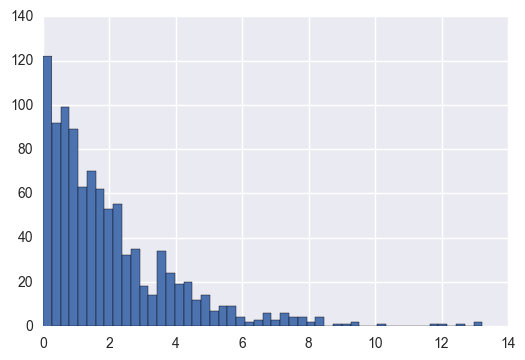

In [249]:
# use the following variable to score one bag distribution

n_test = 1000

horse = np.array([i if i >=0 else 0 for i in np.random.normal(5,2,n_test)])
ball = np.array([i if i >=0 else 0 for i in np.random.normal(1,0.3,n_test)])
bike = np.array([i if i >=0 else 0 for i in np.random.normal(20,10,n_test)])
train = np.array([i if i >=0 else 0 for i in np.random.normal(10,5,n_test)])
doll = np.random.gamma(5,1,n_test)
book = np.random.chisquare(2,n_test)
coal = 47*np.random.beta(0.5, 0.5, n_test)
gloves = 3.0 + np.array([np.random.rand(1)[0] if np.random.rand(1) < 0.3 else np.random.rand(1)[0] for _ in range(n_test)])
block = np.random.triangular(5,10,20,n_test)

_ = plt.hist(book, bins=50)

此处可以使用贪心策略，每一次搜索使每一袋期望最高的组合，之后再将该组合当中最容易用光的物品删除，之后再搜索下一个组合。

搜索策略？穷举貌似不太好？先从小数开始逐个二分？

此处使用了模拟退火算法

搜索策略的编码:

0. ball
1. book
2. gloves
3. doll
4. horse
5. train
6. block
7. bike
8. coal

In [250]:
# save the variable above
reference_vec = np.array([ball, book, gloves, doll, horse, train, block, bike, coal])

# definition of scorer
def scorer(a, get_zero=False):
    """a should be a list of 9 values"""
    ans = np.zeros(1000)
    if len(a) != 9 or a is None:
        return 0
    for i,v in enumerate(a):
        if isinstance(v, float):
            v = int(v+0.5)
        ans += reference_vec[i] * v
    gl = ans>50
    ans[gl] = 0
    if not get_zero:
        return ans.mean()
    else:
        return ans.mean(), float(gl.sum())/len(gl)

In [243]:
def standerize(restrict, x):
    # make variable range from 0 to 1
    g_index = x > 1
    l_index = x < 0
    x[g_index] = 1
    x[l_index] = 0
    return x

def sim_anneling(restrict, r=0.999, maxiter=100):
    """
    restrict is a list that limit the range of each values.
    
    Directly use the simulated annealing algorithm would get many 0 score anwer.
    Therefore when get an bad answer, wo tend to decline the value rather than plus it.
    
    Here I used the zero_rate data to adjust change direction. When
    zero_rate is too large, the direction will tend to be minus.
    """
    threshold_zero = 0.6
    if not isinstance(restrict, np.ndarray):
        restrict = np.array(restrict)
    v = np.random.rand(9)
    # 各个参数可放大倍数
    rescale_ = restrict[:, 1] - restrict[:, 0]
    def rescale(x):
        return x*rescale_ + restrict[:, 0]
    best_v = v
    best_score, zero_rate = scorer(rescale(v), True)
    old_score = best_score
    T, i = 1, 0
    while(i < maxiter):
        i += 1
        dv = np.random.rand(9)
        dv -= zero_rate * zero_rate * 4
        dv = dv / np.sqrt((dv**2).sum())
        dv = dv*T*0.18
        new_v = dv + v
        new_v = standerize(restrict, new_v)
        new_score, zero_rate = scorer(rescale(new_v), True)
        if (new_score - old_score) > -1e-3:
            v = new_v
            old_score = new_score
        elif (np.random.rand()*10 > np.exp(-new_score + old_score)/T)\
             and new_score >= 1.0\
             and zero_rate > threshold_zero:
            v = new_v
            old_score = new_score
            
        if new_score > best_score:
            best_score = new_score
            best_v = v
        if T > 0.0001:
            T *= r
    return rescale(best_v), best_score

In [238]:
# define the default restriction variable
stander_restrict = np.array([[0,5], [0,5], [0,7],[0,25],[0,20],[0,10],[0,10],[0,5],[0,2]])

def stand(x):
    # stupib name, because nothing other came to my head
    # just transfer data type to int
    return np.array([int(i+0.5) for i in x])

def get_best(maxloop=1000, maxiter=100):
    """
    use the sim_anneling function to get best answer
    """
    global restrict
    best_score = 0
    best_v = 0
    for i in range(maxloop):
        a, b = sim_anneling(restrict, maxiter=maxiter)
        if b > best_score:
            best_v = a
            best_score = b
    return stand(best_v), best_score

best_v, best_score = get_best()
print("score:" + str(best_score))

display(best_v)

score:34.1227552088


array([2, 1, 0, 2, 0, 0, 2, 0, 0])

In [251]:
# save and run code
# consider the left bags num

get_di()
ans_list = []
left_bags = 1000
restrict = np.array(stander_restrict, copy=True)
names = ['ball', 'book', 'gloves', 'doll', 'horse', 'train', 'blocks', 'bike', 'coal']
left_num = np.array([1100, 1200, 200, 1000, 1000, 1000, 1000, 500, 166])

def sths(name, num=1):
    global di
    if not isinstance(name, str):
        name = names[name]
    s = (name + "_{} ") * num
    di[name] -= num
    start = di[name]
    return s.format(*[i for i in range(start, start+num)])

def save_v(vector, times):
    """vector"""
    for _ in range(times):
        s = []
        for i, v in enumerate(vector):
            if v <= 0: continue
            s.append(sths(names[i], v))
        if len(s) == 0:
            return
        s = ' '.join(s)
        ans_list.append(s)
        
ans_sum = 0.0

# By test following program for several time, I found
# that it prefer use the first three item, which inc-
# lude ball, book and gloves. And the items which ha-
# s such nice distribution shouldn't be used up so f-
# ast, because it may reduce the chance to reach glo-
# bal optimal.
#
# So I've to add a few lines to make a change and see
# whether this should work.
restrict[0] = [0, 1]
restrict[1] = [0, 1]
restrict[2] = [0, 1]

i = 0
while left_num.sum() and left_bags > 0:
    i += 1
    print(left_bags)
    use, score = get_best()
    print(use)
    print(score)
    if i > 3:
        restrict[:3, 1] += 2
    
    # Calculate which kind of items will be used up first
    minv, mini = 999999, 0
    for i, (left, u) in enumerate(zip(left_num, use)):
        if left < 1e-6 or u < 1e-6: continue
        if float(left) / u < minv:
            minv = float(left) / u
            mini = i
    used_times = min(int(minv), left_bags)
    left_num -= used_times * use
    left_bags -= used_times
    save_v(use, used_times)
    ans_sum += used_times * score
    for i in range(9):
        if left_num[i] < restrict[i][1]:
            restrict[i][1] = left_num[i]
        if left_num[i] < restrict[i][0]:
            restrict[i][0] = left_num[i]
    print('='*20)

print("score:" + str(ans_sum))
print("left:" + str(left_bags))
print("left_item:" + str(left_num))



1000
[0 0 1 1 2 1 1 0 0]
35.7258992337
800
[1 0 0 1 2 1 1 0 0]
35.3151095111
500
[3 1 0 2 0 1 1 0 0]
34.8004784191
250
[4 0 0 0 0 1 2 0 0]
34.2248657451
238
[2 1 0 0 0 1 2 0 0]
33.7012335002
237
[0 1 0 0 0 1 2 0 0]
33.4169010104
125
[0 2 0 0 0 1 0 1 0]
29.6715933312
score:34335.8740069
left:0
left_item:[  0 587   0   0   0   0   0 375 166]


In [252]:
ans = pd.DataFrame(ans_list, columns=['Gifts'])

ans = ans[:1000]

ans.to_csv('ans.csv', index=False)

print(ans_sum)

34335.8740069
